In [30]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn_pandas.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from haversine import haversine
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [3]:
#load data
df = pd.read_csv("kc_house_data.csv")

In [6]:
#train-test split
y = np.log(df['price'])
X = df.drop(columns=['price', 'id', 'date'])
X['log_sqft_living']= np.log(X['sqft_living'].astype(np.float32))
X['sqft_lot']= X['sqft_lot'].astype(np.float32)
X = X.drop(columns=['sqft_living','sqft_lot'])
X['distance_from_billgates']=X.apply(lambda row: dist_from_bill(row['lat'], row['long']), axis=1)
X = X.drop(columns=['sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 
                    'sqft_living15', 'sqft_lot15', 'zipcode'])
# X = X.drop(columns=['waterfront'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=30)

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17277 entries, 11632 to 5925
Data columns (total 9 columns):
bedrooms                   17277 non-null int64
bathrooms                  17277 non-null float64
floors                     17277 non-null float64
waterfront                 15333 non-null float64
view                       17233 non-null float64
condition                  17277 non-null int64
grade                      17277 non-null int64
log_sqft_living            17277 non-null float32
distance_from_billgates    17277 non-null float64
dtypes: float32(1), float64(5), int64(3)
memory usage: 1.3 MB


In [4]:
# Create transformers

class CategoryCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        pass
    
    def transform(self, X):
        return np.array([(value if value in (1, 2, 3, 4) else 0) for value in X],
                       dtype=np.uint8)

class IntConverter(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        pass
    
    def transform(self, X):
        return X.astype(np.uint8)

In [8]:
mapper = DataFrameMapper([
    (['log_sqft_living'], StandardScaler()),
    (['distance_from_billgates'], StandardScaler()),
    (['condition'], StandardScaler()),
    (['grade'], StandardScaler()),
    (['floors'], StandardScaler()),
   # (['zipcode'], OneHotEncoder(categories='auto', dtype=np.uint8)),
#     (['floors'], OneHotEncoder(categories='auto', dtype=np.uint8)),
    (['waterfront'], CategoryCleaner()),
    (['view'], CategoryCleaner()),
    (['bedrooms'], IntConverter()),
    (['bathrooms'], IntConverter())
    ], df_out=True)

mapper.fit(X_train)
X_train_clean = mapper.transform(X_train)
X_test_clean = mapper.transform(X_test)

In [9]:
lr=LinearRegression()
lr.fit(X_train_clean,y_train)
y_pred=lr.predict(X_test_clean)

In [10]:
lr.score(X_train_clean, y_train)

0.7711365753812796

In [11]:
lr.score(X_test_clean, y_test)

0.764018477563301

In [12]:
coef = lr.coef_.tolist()
zip_coef = list(zip(coef, X_train_clean.columns))
zip_coef.sort()
zip_coef

[(-0.22936903113659712, 'distance_from_billgates'),
 (-0.04005897963199018, 'bedrooms'),
 (0.006982293549336568, 'floors'),
 (0.024835032368500234, 'bathrooms'),
 (0.04679076884408008, 'condition'),
 (0.07688427234907279, 'view'),
 (0.1754086539114694, 'grade'),
 (0.21376423748935275, 'log_sqft_living'),
 (0.40233928795086515, 'waterfront')]

In [ ]:
# transform data

In [5]:
def dist_from_bill(lat, long):
    """returns a km distance from Bill and Melinda Gates' Medina residence"""
    gates_lat = 47.62774
    gates_long = -122.24194
    return haversine((lat, long), (gates_lat, gates_long))

In [23]:
dist_from_bill(1,1)

12329.845149186951

Graphs of distance from bill gates vs log price and waterfront vs log price

[]

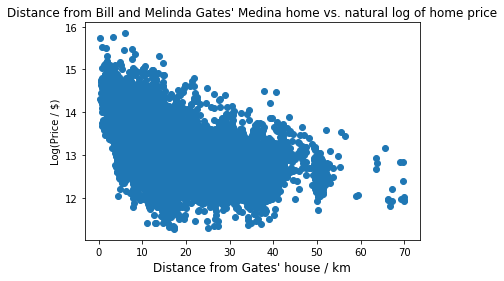

In [16]:
plt.scatter(X['distance_from_billgates'],y)
plt.title("Distance from Bill and Melinda Gates' Medina home vs. natural log of home price",
         fontsize='large')
plt.xlabel("Distance from Gates' house / km", fontsize='large')
plt.ylabel("Log(Price / $)")
plt.plot()

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


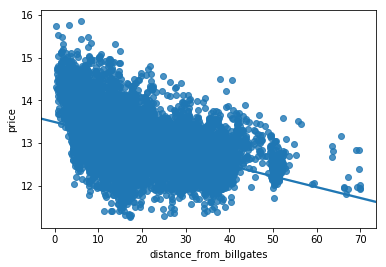

In [31]:
sns.regplot(X['distance_from_billgates'],y)

In [32]:
X2 = sm.add_constant(X['distance_from_billgates'])
model = sm.OLS(y,X2)
results = model.fit()
results.params

const                      13.493377
distance_from_billgates    -0.025415
dtype: float64

In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     6810.
Date:                Thu, 22 Aug 2019   Prob (F-statistic):               0.00
Time:                        22:24:01   Log-Likelihood:                -13832.
No. Observations:               21597   AIC:                         2.767e+04
Df Residuals:                   21595   BIC:                         2.768e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      13.4934      0.006   2164.543      0.000      13.481      13.506
distance_from_billgates    -0.0254      0.000    -82.523      0.000      -0.026      -0.025
==============================================================================
Omnibus:                      848.015   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1324.252
Skew:                           0.363   Prob(JB):                    2.77e-288
Kurtosis:                       3.972   Cond. No.                         40.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


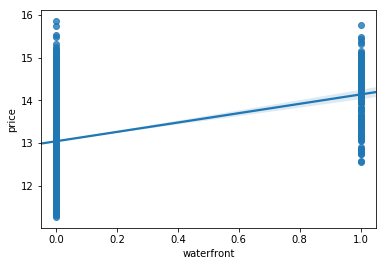

In [47]:
sns.regplot(waterfront_1_df['waterfront'],y3)

In [45]:
waterfront_1_df = df[(df['waterfront']==1)|(df['waterfront']==0)]
y3 = np.log(waterfront_1_df['price'])

X3 = sm.add_constant(waterfront_1_df['waterfront'])
model = sm.OLS(y3,X3)
results = model.fit()
results.params

const         13.041237
waterfront     1.096569
dtype: float64

In [44]:
waterfront_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19221 entries, 1 to 21596
Data columns (total 21 columns):
id               19221 non-null int64
date             19221 non-null object
price            19221 non-null float64
bedrooms         19221 non-null int64
bathrooms        19221 non-null float64
sqft_living      19221 non-null int64
sqft_lot         19221 non-null int64
floors           19221 non-null float64
waterfront       19221 non-null float64
view             19164 non-null float64
condition        19221 non-null int64
grade            19221 non-null int64
sqft_above       19221 non-null int64
sqft_basement    19221 non-null object
yr_built         19221 non-null int64
yr_renovated     15809 non-null float64
zipcode          19221 non-null int64
lat              19221 non-null float64
long             19221 non-null float64
sqft_living15    19221 non-null int64
sqft_lot15       19221 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.2+ MB


In [48]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     647.4
Date:                Thu, 22 Aug 2019   Prob (F-statistic):          1.71e-140
Time:                        22:34:33   Log-Likelihood:                -14657.
No. Observations:               19221   AIC:                         2.932e+04
Df Residuals:                   19219   BIC:                         2.933e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0412      0.004   3472.081      0.000      13.034      13.049
waterfront     1.0966      0.043     25.445      0.000       1.012       1.181
==============================================================================
Omnibus:                      552.767   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              662.911
Skew:                           0.367   Prob(JB):                    1.12e-144
Kurtosis:                       3.537   Cond. No.                         11.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""